##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 합성곱 변이형 오토인코더

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    TensorFlow.org에서 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    구글 코랩(Colab)에서 실행하기</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    깃허브(GitHub)소스 보기</a>
  </td>
</table>

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도
불구하고 [공식 영문 문서](https://www.tensorflow.org/?hl=en)의 내용과 일치하지 않을 수 있습니다.
이 번역에 개선할 부분이 있다면
[tensorflow/docs](https://github.com/tensorflow/docs) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다.
문서 번역이나 리뷰에 참여하려면
[docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로
메일을 보내주시기 바랍니다.

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

이 노트북은 변이형 오토인코더(Variational Autoencoder, VAE)를 훈련시켜 손글씨 이미지를 생성하는 방법을 소개합니다 ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)).



In [2]:
# GIF를 만들기 위해 설치합니다.
!pip install -q imageio

## 텐서플로우 및 기타 라이브러리 불러오기

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version 명령은 코랩에서만 사용 가능합니다.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## MNIST 데이터셋 불러오기
각 MNIST 이미지는 0에서 255 사이의 값을 취하는 784개의 정수로 이루어진 행렬이며, 이때 이 값들은 사진 내 픽셀의 진하기를 나타냅니다. 간단한 전처리 과정으로, 각 픽셀을 0에서 1 사이의 값으로 정규화한 후 이진수화(binarization)을 통해 베르누이 분포로 모델링합니다.

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# 픽셀값을 [0., 1.] 범위에 속하도록 정규화합니다.
train_images /= 255.
test_images /= 255.

# 이진수화를 통해 베르누이 분포로 만들어줍니다.
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

## *tf.data*를 이용해 데이터셋 배치화 하기

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## *tf.keras.Sequential*로 생성 네트워크와 추론 네트워크 만들기

이 튜토리얼에서는 간단한 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 생성 네트워크와 추론 네트워크를 만듭니다. 이 합성곱 신경망들은 비교적 간단하기 때문에 `tf.keras.Sequential`를 이용해 쉽게 구현할 수 있습니다. 이하 설명에서 $x$ 와 $z$는 각각 관측값(observation)과 잠재 변수(latent variable)를 나타냅니다. 

### 생성 네트워크
생성 네트워크는 인코딩된 잠재 변수 $z$를 인풋으로 받아 관측값의 조건부 분포, 즉 $p(x|z)$의 파라미터를 출력합니다. 잠재 변수의 사전 분포 $p(z)$는 표준 정규분포로 가정합니다. 

### 추론 네트워크
추론 네트워크는 관측값을 인풋으로 받아 잠재 변수의 근사 사후 분포 $q(z|x)$의 파라미터를 출력합니다. 문제를 단순화하기 위해, 본 예제에서는 사후 분포를 대각 공분산 행렬을 가진 가우시안 분포(diagonal Gaussian)로 가정합니다. 이 가정 하에 추론 네트워크는 사후 가우시안 분포의 평균 및 로그 분산값을 출력하게 됩니다 (분산이 아닌 로그 분산을 사용하는 것은 수치적 안전성을 보장하기 위함입니다).
 
### 파라미터 재조정 기법
훈련 시 사전 분포인 표준 정규분포에서 무작위 샘플을 얻은 후, 이 샘플에 잠재 변수의 표준 편차를 곱하고 평균을 더하여 사후 분포 $q(z|x)$에서 샘플링 할 수 있습니다. 이처럼 파라미터 재조정 기법은 가우시안 샘플링을 거쳐 그래디언트(gradient)를 추론 네트워크의 가중치에 적용합니다. 

### 네트워크 구조
추론 네트워크는 두 개의 합성곱층과 하나의 `Dense`층으로 구성됩니다. 생성 네트워크는 추론 네트워크 구조의 역순으로 하나의 `Dense`층과 세 개의 전치합성곱층(역합성곱층이라고도 불립니다)을 사용합니다. 미니 배치(mini-batch)의 사용은 불확정성을 증가시켜 모델을 불안정하게 만들 수 있으므로 변이형 오토인코더에는 배치 정규화(batch normalization)를 적용하지 않는 것이 일반적임을 참고합니다.

In [8]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # 마지막 계층에서는 활성화 함수를 쓰지 않습니다.
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # 마지막 계층에서는 활성화 함수를 쓰지 않습니다.
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## 손실 함수와 옵티마이저 정의

변이형 오토인코더는 ELBO(Evidence Lower Bound)를 최대화하는 과정을 통해 학습합니다.

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

실제로는 이 기댓값의 단일 몬테카를로 추정(Monte Carlo estimate)을 최적합니다.
 
$$\log p(x| z) + \log p(z) - \log q(z|x),$$

이때 $z$는 $q(z|x)$에서 샘플된 잠재 변수입니다.

**참고:** 마지막 두 항에 해당하는 쿨백-라이블러 분산값(Kullback–Leibler Divergence, KL)은 분석적으로 계산할 수 있지만 문제를 단순화하기 위해 세 개의 항을 모두 몬테카를로 추정에 포함시킵니다.

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## 훈련

* 데이터셋을 반복합니다.
* 각 에폭(epoch)마다 이미지를 추론 네트워크로 전달하여 근사 사후 분포 $q(z|x)$의 평균 및 로그 분산값을 얻습니다.
* $q(z|x)$에서 샘플링하기 위해 앞서 소개한 *파라미터 재조정 기법*을 적용합니다.
* 마지막으로, 생성 분포 $p(x|z)$의 로짓(logit)을 획득하기 위해 파라미터 재조정 과정을 거친 잠재 변수를 생성 네트워크에 전달합니다.
* **참고:** 본 튜토리얼에서는 케라스의 데이터셋에서 불러온 6만장의 훈련 세트 이미지와 1만장의 테스트 세트 이미지를 사용합니다. 그렇기 때문에 테스트 세트에 대한 ELBO는 동적 이진수화(dynamic binarization)를 거친 Larochelle의 MNIST 데이터셋을 사용한 문헌에서 보고된 통상적인 수치보다 다소 높을 수 있습니다.

## 이미지 생성하기

* 훈련이 완료되면 이미지를 생성할 차례입니다.
* 사전 표준 정규분포 $p(z)$에서 잠재 변수를 샘플링합니다.
* 생성 네트워크는 잠재 변수 $z$를 관측값의 로짓으로 변환하여 $p(x|z)$를 모델링합니다. 
* 생성 네트워크의 출력값인 각 픽셀에 대한 베르누이 분포의 파라미터를 이미지로 나타냅니다.

In [10]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# 이미지 생성을 위한 랜덤 벡터를 저장함으로써
# 훈련에 따른 모델의 향상을 쉽게 볼 수 있습니다.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [11]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout 설정은 그래프 사이의 겹침을 최소화시킵니다.
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Epoch: 100, Test set ELBO: -77.78366088867188, time elapse for current epoch 1.6644511222839355


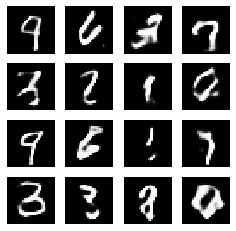

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)

### 에폭 수에 따른 이미지 진열하기

In [13]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

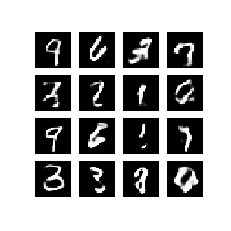

In [14]:
plt.imshow(display_image(epochs))
plt.axis('off') # 축 없이 이미지만 보여줍니다.

### 저장된 이미지로 GIF 만들기

In [15]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

코랩에서 작업하고 있다면, 다음 코드를 통해 GIF 애니메이션을 다운로드 받을 수 있습니다:

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)